# Final Project Submission
- Student Name - Vinayak Modgil
- Student pace - Full time
- Scheduled project review time/date - 13/09/2021
- Instructor name - Yish Lim
- Plog Post URL - [Github](#https://github.com/vinayakmodgil/Deep-learning-Image-Classification-/blob/master/xray-main-vinayak.ipynb)

# **Diagnosing Pnuemonia using Deep Learning**
by Vinayak Modgil <br> <br>
In this project, I follow the key fundamentals to a Data Science project and Deep Learning to diagnose pneumonia from a given set of images. The overview of the procedure followed:
1. [Data Collection](#Data-Collection)
2. [Data Processing](#Data-Processing)
3. [Data Understanding](#Data-Understanding)
4. [Data Modeling](#Data-Modeling)
5. [Data Interpretation](#Data-Interpretation)

## Business Statement
Pneumonia is an inflammatory disease cause by infection with viruses or bacteria in the lungs. Pneumonia can be lethal if not treated, so it is better to diagnose it during the ealry onset.

Pneumonia can be diagnosed by doctor's expertise based on evaluating the patient's symptoms. It can also be diagnosed by X-ray imaging interpreted by a radiologist or a phyisician.

## Analysis and Methodology
In this analysis I will extract, explore and model on X-ray images with the help of Convolutional Neural Networks. A CNN is a type of artifical neural network used in image recognition and processing that is specifically designed to process pixel data.

CNNs are powerful image processing, artificial intelligence that use deep learning to perform generative and predictive tasks. A CNN uses system much like a perceptron that has been designed for reduced processing requirements. The layers of a CNN consist of an input layer, pooling layers and fully connected layers.




## Data Collection

## Import necessary packages

In [85]:
import pandas as pd
import os, sys, glob
import cv2

#Data wrangling packages
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#Neural Network packages
import tensorflow as tf

from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

#Data evaluation metrics packages
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

#ML packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#Deep Learning hyperparameter tuning
import talos

#Intepret DL model
import lime
from lime import lime_image
from lime import lime_base
from skimage.segmentation import mark_boundaries



In [2]:
train_folder = "data/chest_xray/chest_xray/train"
test_folder = "data/chest_xray/chest_xray/test"
val_folder = "data/chest_xray/chest_xray/val"

In [3]:
def n_images_identifier(base_folder="data/chest_xray/chest_xray/"):
    '''
    returns the number of different
    types of images in the folders
    
    n_images_identifies: (Arguments)
    - base folder : common folder holding all the images.
    '''
    #Takes the folder type as normal or pneumonia
    folder_type = ["NORMAL", "PNEUMONIA"]
    #
    train_folder = base_folder + "train/"
    test_folder = base_folder + "test/"
    val_folder = base_folder + "val/"
    
    # iterates for folder in train_folder, test_folder
    #and val_folder
    for folder in [train_folder, test_folder, val_folder]:
        
        #Further iterates for _type in folder_type
        for _type in folder_type:
            if _type=="NORMAL":
                n_normal = len(os.listdir(folder + _type))
            else:
                n_infected = len(os.listdir(folder + _type))
        print(f"Set: {folder}, normal images: {n_normal}, infected images: {n_infected}")
        print(f"Folder {folder} has a total of {n_normal+n_infected} images\n")
        
        #Plot the graph of normal and infected area
        plt.figure(figsize=(6, 6))
        sns.barplot(["Normal", "Pneumonia"], [n_normal, n_infected])
        plt.ylabel("Number of images", fontsize=14)
        plt.title(f"{folder} distribution", fontsize=16)
    print("Class imbalance for train and test set")
    return 
    

Set: data/chest_xray/chest_xray/train/, normal images: 1342, infected images: 3876
Folder data/chest_xray/chest_xray/train/ has a total of 5218 images

Set: data/chest_xray/chest_xray/test/, normal images: 234, infected images: 390
Folder data/chest_xray/chest_xray/test/ has a total of 624 images

Set: data/chest_xray/chest_xray/val/, normal images: 9, infected images: 9
Folder data/chest_xray/chest_xray/val/ has a total of 18 images

Class imbalance for train and test set


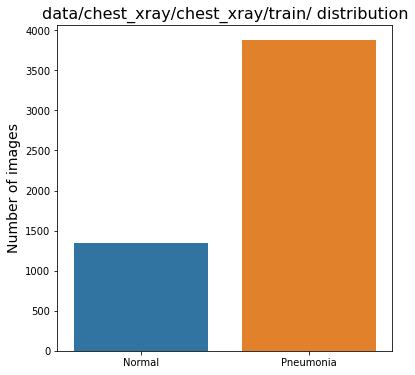

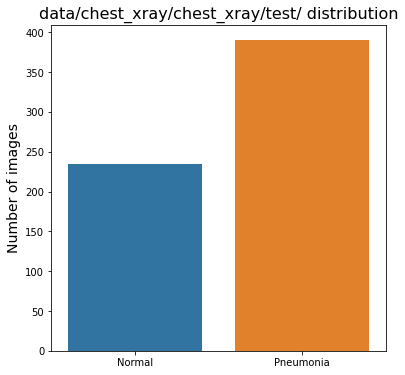

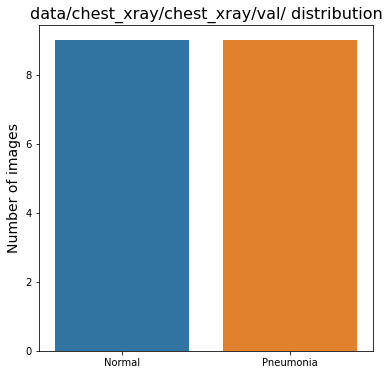

In [4]:
#Call the function
n_images_identifier()

## Data Processing

In [5]:
def data_processing(img_dims,
                    batch_size=None,
                    base_folder="data/chest_xray/chest_xray/"):
    '''
    this function helps in processing data and converts 
    images to arrays of 3 dimensions.
    
    data_processing:
    - img_dims: Dimensions of the image
    - batch_size= None if not specified else an integer
    - base_folder: folder where the data lies
    '''
    train_folder = base_folder + "train/"
    test_folder = base_folder + "test/"
    val_folder = base_folder + "val/"

    #Data genereation objects
    train_images = ImageDataGenerator(rescale=1./255)
    test_val_images = ImageDataGenerator(rescale=1./255, validation_split=0.2,)
    
    
    #Use flow from directory to get train and test 
    #images
    if batch_size != None:

        train_chest = train_images.flow_from_directory(
        directory=train_folder,
        target_size=(img_dims, img_dims),
        batch_size=batch_size, 
        classes = ["NORMAL", "PNEUMONIA"],
        class_mode="binary", 
        shuffle=False)
    
        test_chest = test_val_images.flow_from_directory(
        directory=test_folder, 
        target_size=(img_dims, img_dims),
        subset="training",
        batch_size=batch_size, 
        classes=["NORMAL", "PNEUMONIA"],
        class_mode="binary", 
        shuffle=False)

        val_chest = test_val_images.flow_from_directory(
        directory=test_folder,
        target_size=(img_dims, img_dims),
        subset="validation",
        batch_size = batch_size,
        classes=["NORMAL", "PNEUMONIA"],
        class_mode="binary",
        shuffle=False)

        return train_chest, test_chest, val_chest, batch_size

In [6]:
#Calling function
train_gen, test_gen, val_gen, batch_size= data_processing(80, batch_size=32)

Found 5216 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


## Data Understanding

In [7]:
import matplotlib.image as mpimg

def plot_images(path, max_images=6):
    '''
    searches for 6 images in the folder mentioned
    as an argument and plots them.
    
    plot_images:
    - path: path of the images
    - max_images: 6 if not mentioned else an integer
    '''
    amount = 0
    fig =  plt.figure(figsize=(12, 6))
    #Iterate through path using for loop
    for file in os.listdir(path):
        if file.endswith(".jpeg"):
           if amount == max_images:
               break
           img = mpimg.imread(os.path.join(path, file))
           plt.subplot(230+1+amount)
           plt.title(path[33:])
           imgplot = plt.imshow(img)

           amount += 1




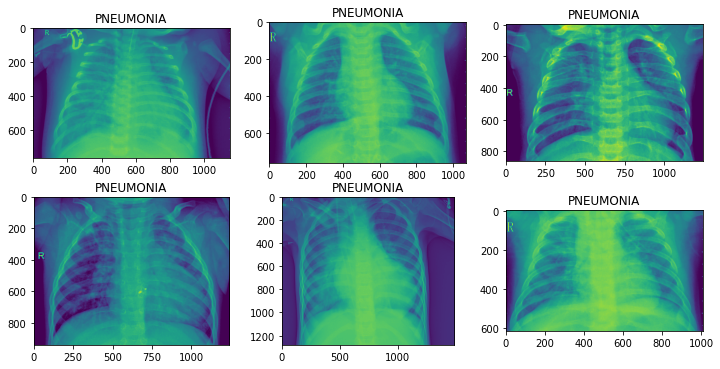

In [8]:
#Call the function for infected images
plot_images(path = train_folder + "/PNEUMONIA")

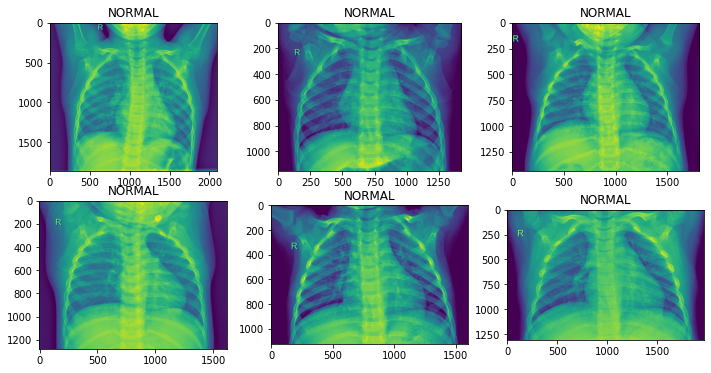

In [9]:
# Call the function for normal images
plot_images(train_folder+"/NORMAL")

I create a class of Convolutional Neural Network model which will contain functions created from the use of Tensorflow to help build us our model.

In [10]:
# class CNN_model:
#     '''
#     Using OOP to create a class for Convolutional Neural
#     Network.
#     '''

#     def add_weights(self, shape):
#         '''
#         A method to create weight connections for all 
#         the layers.
#         '''

#         return tf.Variable(tf.random.truncated_normal(shape=shape, stddev=0.05))

#     def bias(self, shape):
#         '''a method to create biases for all the connections'''

#         return tf.Variable(tf.constant(0.05, shape=shape))
    
#     def conv_layer(self, prev_layer, kernel, input_shape,output_shape, stride):
#         '''create convolution layers with the weights'''
#         weights = self.add_weights([kernel, kernel, input_shape, output_shape])

#         bias = self.bias([output_shape])

#         stride = [1, stride, stride, 1]
        
#         c_layer = tf.nn.conv2d(prev_layer, weights, stride, padding="SAME") + bias
#         return c_layer
    
#     def pooling_layer(self, c_layer, size, stride_s):
#         '''create the pooling layer'''
#         kernel =[1, size, size, 1]
#         stride = [1, stride_s, stride_s, 1]
#         p_layer = tf.nn.max_pool(c_layer, kernel, stride, padding="SAME")
#         return p_layer

#     def flat_layer(self, prev_layer):
#         '''A method to flatten the 2D features into single dimension'''
#         input_size = prev_layer.get_shape().as_list()
#         output_size = input_size[-1]*input_size[-2]*input_size[-3]
#         return tf.reshape(prev_layer, [-1, output_size]), output_size
    
#     def fc_layer(self, prev_layer, input_shape, output_shape):
#         '''Creates fully connected layer'''
#         weights = self.add_weights([input_shape, output_shape])
#         bias = self.bias([output_shape])
#         fc = tf.add(tf.matmul(prev_layer, weights), bias)
#         return fc
    
#     def activation(self, layer):
#         '''We define the activation layer which uses the relu activation function'''
#         return tf.nn.relu(layer)

#     def dropout(self, layer):
#         ''''''
#         return tf.nn.dropout(layer, 0.5)




In [11]:
# def create_CNN(image, number_of_class):
#     # create the first convolutional layer
#     c1 = CNN_model.conv_layer(image, 5, 8, 16, 1)
#     p1 = CNN_model.pooling_layer(c1, 5, 2)
#     l1 = CNN_model.activation(p1)

#     #Create second convolutional layer
#     c2 = CNN_model.conv_layer(l1, 4, 16, 32, 1)
#     p2 = CNN_model.pooling_layer(c2, 5, 2)
#     l2 = CNN_model.activation(p2)

#     #Create third convolutional layer
#     c3 = CNN_model.conv_layer(l2, 3, 32, 64, 1)
#     p3 = CNN_model.pooling_layer(c3, 5, 2)
#     l3 = CNN_model.activation(p3)

# #Convert the 2D activations into single vector
#     emb1, length = CNN_model.flat_layer(l3)

# #Feed the network to the fully connected layer
#     emb2 = CNN_model.fc_layer(emb1, length, 1024)

# # Compute the activation
#     emb3 = CNN_model.activation(emb2) #Apply dropout
#     emb4 = CNN_model.dropout(emb3)  # Output layer

# #feed the previous activations to the output layer
#     net = CNN_model.fc_layer(emb3, 1024, number_of_class)
#     print(net)
#     return net

    


In [12]:
# session = tf.compat.v1.Session()

# def trainer(number_of_images):

#     z_train = create_CNN(train_images, 2)
#     z_test = create_CNN(test_images, 2)
#     z_val = create_CNN(val_images, 2)
    
#     y = tf.nn.softmax(z)

#     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=z),
#     labels=train_labels)

#     tf.summary.scalar("cost", cost)

#     optimizer = tf.train.AdamOptimizer().minimize(cost)

#     correct_prediction = tf.equal(tf.argmax(train_labels, 1),tf.argmax(y, 1))

#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#     # initialize the optimizer
#     session.run(tf.global_variables_initializer())

#     merged = tf.summary.merge_all()

#     saver = tf.train.Saver(max_to_keep = 4)

#     total_batch_train = batch_size_train
#     total_batch_test = batch_size_test
#     total_batch_val = batch_size_val








## Data Preparation for Modeling

In [13]:
#Print class indices
print(train_gen.class_indices)
print(test_gen.class_indices)
print(val_gen.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [14]:
#Get the length of folders
train_size = len(train_gen.filenames)
test_size = len(test_gen.filenames)
val_size = len(val_gen.filenames)

train_size, test_size, val_size


(5216, 500, 124)

In [15]:
# def cnn_model(train_img, train_y, test_img, test_y):

#     model = Sequential()

#     ## hidden layers
#     model.add(Conv2D(params["nodes_cnn"], (3, 3),
#     activation=params["activation_cnn"],
#     input_shape=(80, 80, 3)))
#     model.add(MaxPooling2D((2, 2)))
#     #


### Basline Model


In [16]:
## Initializing the CNN
def baseline_model():
        model = Sequential()

        #Add a convolution layer with 32 kernels of 3x2 shape
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(80, 80, 3)))

        model.add(MaxPooling2D((2, 2)))

        # Add another convolution layer
        model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
        model.add(MaxPooling2D((2,2)))

        model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
        model.add(MaxPooling2D((2, 2)))

        #Flattening the layer before fully connected layers
        model.add(Flatten())

        #Fully connected layer with 256 neurons
        model.add(Dense(256, activation="relu"))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["acc"])
        #Model summary
        model.summary()
        return model

In [17]:
model = baseline_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0

In [18]:
# Fit the baseline model
history_base = model.fit_generator(train_gen,
                              epochs=10,
                              steps_per_epoch=train_size//batch_size,
                              validation_steps=val_size//batch_size,
                              validation_data=val_gen)

Epoch 1/10
163/163 [==============================] - 72s 437ms/step - loss: 0.7140 - acc: 0.7427 - val_loss: 0.6032 - val_acc: 0.6979
Epoch 2/10
163/163 [==============================] - 61s 376ms/step - loss: 1.0116 - acc: 0.7611 - val_loss: 1.0548 - val_acc: 0.5312
Epoch 3/10
163/163 [==============================] - 58s 354ms/step - loss: 0.4089 - acc: 0.8207 - val_loss: 1.0467 - val_acc: 0.5625
Epoch 4/10
163/163 [==============================] - 67s 414ms/step - loss: 0.3042 - acc: 0.8660 - val_loss: 1.7604 - val_acc: 0.5833
Epoch 5/10
163/163 [==============================] - 68s 418ms/step - loss: 0.5231 - acc: 0.8428 - val_loss: 0.7250 - val_acc: 0.6875
Epoch 6/10
163/163 [==============================] - 61s 375ms/step - loss: 0.3396 - acc: 0.8719 - val_loss: 1.4815 - val_acc: 0.5625
Epoch 7/10
163/163 [==============================] - 68s 415ms/step - loss: 0.2039 - acc: 0.9174 - val_loss: 1.2870 - val_acc: 0.5729
Epoch 8/10
163/163 [==============================] - 6

In [19]:
#loss and acc of our model
history_base.history

{'loss': [0.713985025882721,
  1.01164972782135,
  0.4089455306529999,
  0.3042146563529968,
  0.5230783224105835,
  0.33964458107948303,
  0.20391690731048584,
  0.13101862370967865,
  0.12044867128133774,
  0.10191763192415237],
 'acc': [0.7427147030830383,
  0.7611196041107178,
  0.8207438588142395,
  0.8659892678260803,
  0.8427914381027222,
  0.8719325065612793,
  0.9173696041107178,
  0.9484279155731201,
  0.9520705342292786,
  0.9605061411857605],
 'val_loss': [0.6031833291053772,
  1.0548384189605713,
  1.0467151403427124,
  1.7603864669799805,
  0.7249588966369629,
  1.4815260171890259,
  1.287044644355774,
  2.7161943912506104,
  1.8815594911575317,
  1.595984935760498],
 'val_acc': [0.6979166865348816,
  0.53125,
  0.5625,
  0.5833333134651184,
  0.6875,
  0.5625,
  0.5729166865348816,
  0.5729166865348816,
  0.59375,
  0.6041666865348816]}

## Data Modeling

In [20]:
def model_eval(model, history):
    '''
    This function evaluates the CNN model
    by printing a classification report
    and plotting a confusion matrix and a 
    line plot for training loss, accuracy 
    '''
    train_loss = history.history['loss']
    validation_loss = history.history["val_loss"]

    train_accuracy = history.history["acc"]
    validation_accuracy = history.history["val_acc"]

    #line plot of train_accuracy
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

    #plotting accuracy
    ax[0].plot(train_accuracy, label="Training accuracy", color="red")
    ax[0].plot(validation_accuracy, label="Validation accuracy", color="green")
    ax[0].legend()

    #Plotting loss
    ax[1].plot(train_loss, label="Training loss", color="red")
    ax[1].plot(validation_loss, label = "validation loss", color="green")
    ax[1].legend()
    plt.show()

    predictions = model.predict_generator(test_gen, steps = test_size/batch_size)

    y_pred = (predictions> 0.5).astype(int)
    y_true = test_gen.classes

    #Getting classification report
    print("***"*10)
    print("Classification Report")
    print("***"*10)

    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

    #Plotting confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["NORMAL", "PNEUMONIA"])
    ax.yaxis.set_ticklabels(["NORMAL", "PNEUMONIA"])
    plt.show()

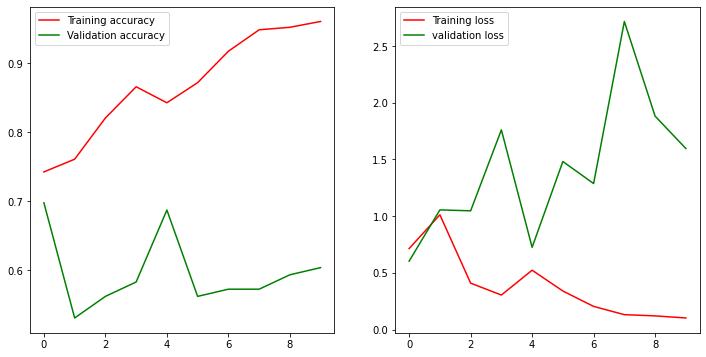

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       0.96      0.35      0.51       188
   PNEUMONIA       0.72      0.99      0.83       312

    accuracy                           0.75       500
   macro avg       0.84      0.67      0.67       500
weighted avg       0.81      0.75      0.71       500



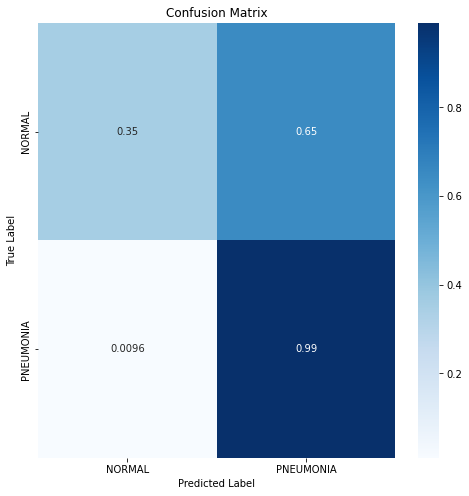

In [21]:
#Call the function for evaluating model
model_eval(model, history_base)

Looking at this model, we can see that the accuracy is 81%, which is decent for a baseline model, and it can predict 98% of the pneumonia cases. The model has a high rate of false positive test results (48%) which means that the ability of the model to predict normal xray images is limited.

## Model 1


In [22]:
def model_1st():
    '''
    a CNN model
    '''
    #Initialize the model
     model_1 = Sequential()

     #Adding convolution layer no 1
     model_1.add(Conv2D(32, kernel_size=(3,3), padding="same", activation="relu",input_shape=(80,80,3)))
     #Adding a MaxPooling layer
     model_1.add(MaxPooling2D((2,2)))
     #Add Convolution layer no 2
     model_1.add(Conv2D(63, kernel_size=(3,3), padding="same", activation="relu"))
     #Add a MaxPooling layer
     model_1.add(MaxPooling2D((2,2)))
     #Add convolution layer no 3
     model_1.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
     #Add a MaxPooling layer
     model_1.add(MaxPooling2D((2,2)))
     #Add convolution layer no 4
     model_1.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
     #Add a maxpooling layer
     model_1.add(MaxPooling2D((2,2)))

     #Flatten the layer
     model_1.add(Flatten())
     #Add a fully connected layer
     model_1.add(Dense(64, activation="relu"))
     model_1.add(Dense(128, activation="relu"))
     model_1.add(Dense(256, activation="relu"))
     model_1.add(Dense(512, activation="relu"))

     model_1.add(Dense(1, activation="sigmoid"))
    
     #Compile the model
     model_1.compile(loss="binary_crossentropy",optimizer="adam", metrics=["acc"])
    
    #Model summary
     model_1.summary()
     return model_1





In [23]:
model_1 = model_1st()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 63)        18207     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 63)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 128)       72704     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 128)      

In [24]:
# Fit the model
history_1 = model_1.fit_generator(train_gen, epochs=10,
                             steps_per_epoch=train_size//batch_size,
                             validation_steps=val_size//batch_size,
                             validation_data=val_gen)

Epoch 1/10
163/163 [==============================] - 69s 419ms/step - loss: 0.8950 - acc: 0.7429 - val_loss: 0.7389 - val_acc: 0.5208
Epoch 2/10
163/163 [==============================] - 61s 373ms/step - loss: 0.6678 - acc: 0.7418 - val_loss: 0.7314 - val_acc: 0.5000
Epoch 3/10
163/163 [==============================] - 57s 352ms/step - loss: 0.4725 - acc: 0.8008 - val_loss: 1.2247 - val_acc: 0.5729
Epoch 4/10
163/163 [==============================] - 58s 353ms/step - loss: 0.3347 - acc: 0.8568 - val_loss: 1.8718 - val_acc: 0.5833
Epoch 5/10
163/163 [==============================] - 59s 362ms/step - loss: 0.4217 - acc: 0.8614 - val_loss: 1.0794 - val_acc: 0.5625
Epoch 6/10
163/163 [==============================] - 67s 412ms/step - loss: 0.2648 - acc: 0.8953 - val_loss: 1.9832 - val_acc: 0.5521
Epoch 7/10
163/163 [==============================] - 75s 456ms/step - loss: 0.1976 - acc: 0.9235 - val_loss: 1.8605 - val_acc: 0.6250
Epoch 8/10
163/163 [==============================] - 6

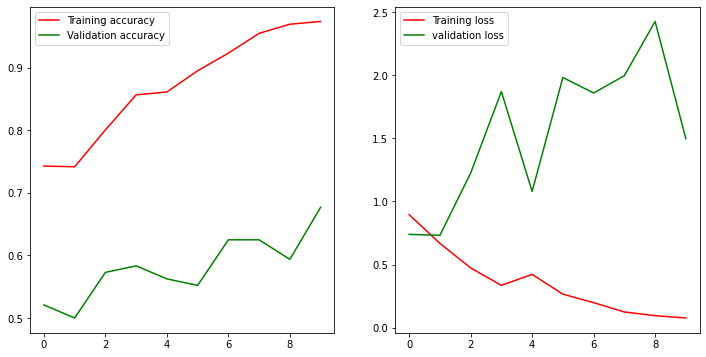

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       0.91      0.56      0.70       188
   PNEUMONIA       0.79      0.97      0.87       312

    accuracy                           0.82       500
   macro avg       0.85      0.77      0.78       500
weighted avg       0.83      0.82      0.80       500



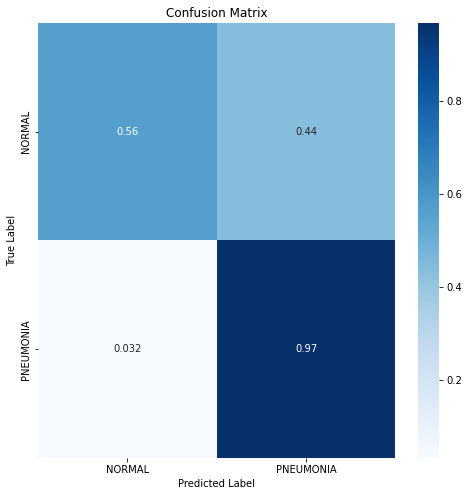

In [25]:
model_eval(model_1, history_1)

## Model 2

In [26]:
def model_2nd():
    #Initialize a sequential model
    model_2 = Sequential()
    #Add a convolutional layer(32 nodes)
    model_2.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(80,80,3)))
    #Add a MaxPooling layer
    model_2.add(MaxPooling2D((2,2)))
    
    # Add a convolutional layer(64 nodes)
    model_2.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    # Add a MaxPooling layer
    model_2.add(MaxPooling2D((2,2)))
    
    #Add a convolutional layer(128 nodes)
    model_2.add(Conv2D(128,kernel_size=(3,3), padding="same", activation="relu"))
    #Add a MaxPooling layer
    model_2.add(MaxPooling2D((2,2)))
    
    #Add a convolutional layer(128 nodes)
    model_2.add(Conv2D(128,(3,3), padding="same", activation="relu"))
    #Add a MaxPooling layer
    model_2.add(MaxPooling2D(2,2))

    #Flattening the layer before fully connected layers
    model_2.add(Flatten())
    
    #Fully connected layers
    model_2.add(Dense(128, activation="relu"))
    model_2.add(Dropout(0.1))

    model_2.add(Dense(256, activation="relu"))
    model_2.add(Dense(512, activation="relu"))
    model_2.add(Dense(1, activation="sigmoid"))
    
    #Compile the model
    model_2.compile(loss="binary_crossentropy", optimizer="adam",metrics=["acc"])
     
    #Give model summary
    model_2.summary()
    return model_2





In [27]:
model_2 = model_2nd()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 19, 19, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 128)        

In [28]:
history_2 = model_2.fit_generator(train_gen, epochs=10, steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, validation_data=val_gen)

Epoch 1/10
163/163 [==============================] - 63s 383ms/step - loss: 0.5634 - acc: 0.7322 - val_loss: 4.1726 - val_acc: 0.5208
Epoch 2/10
163/163 [==============================] - 67s 410ms/step - loss: 0.7063 - acc: 0.8002 - val_loss: 1.5871 - val_acc: 0.5312
Epoch 3/10
163/163 [==============================] - 68s 413ms/step - loss: 0.3448 - acc: 0.8409 - val_loss: 1.5110 - val_acc: 0.5833
Epoch 4/10
163/163 [==============================] - 61s 377ms/step - loss: 0.2677 - acc: 0.8794 - val_loss: 1.2409 - val_acc: 0.7083
Epoch 5/10
163/163 [==============================] - 66s 403ms/step - loss: 0.2083 - acc: 0.9187 - val_loss: 1.0407 - val_acc: 0.6771
Epoch 6/10
163/163 [==============================] - 62s 380ms/step - loss: 0.2030 - acc: 0.9291 - val_loss: 2.6206 - val_acc: 0.5312
Epoch 7/10
163/163 [==============================] - 70s 433ms/step - loss: 0.3296 - acc: 0.8938 - val_loss: 0.6001 - val_acc: 0.6667
Epoch 8/10
163/163 [==============================] - 6

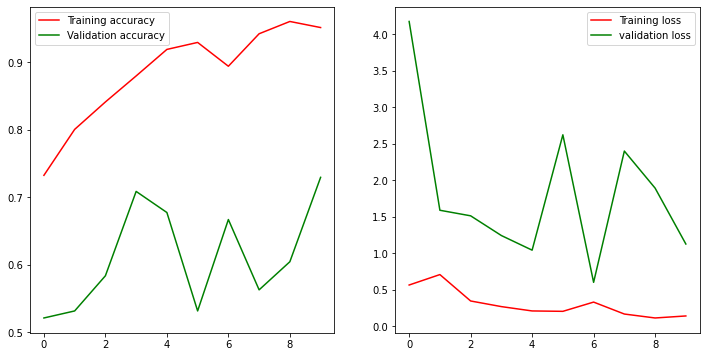

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       0.93      0.69      0.79       188
   PNEUMONIA       0.84      0.97      0.90       312

    accuracy                           0.86       500
   macro avg       0.89      0.83      0.85       500
weighted avg       0.87      0.86      0.86       500



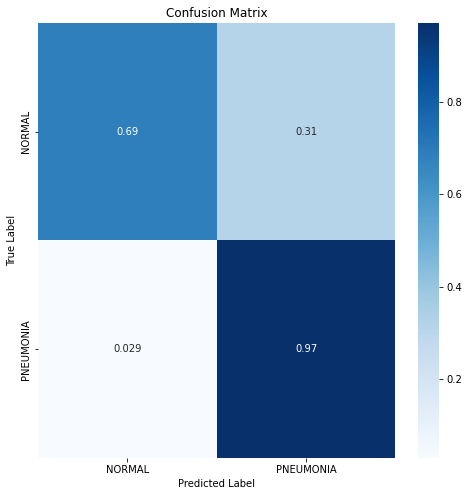

In [29]:
#Use model_eval to gain info on the data
model_eval(model_2, history_2)

## Model 3

In [30]:
#length of specific folders
pneumonia = len(os.listdir(os.path.join(train_folder, "PNEUMONIA")))
normal = len(os.listdir(os.path.join(train_folder+ "/NORMAL")))
pneumonia, normal

(3876, 1342)

In [31]:
#class 1 and class 2
class_1 = pneumonia / (normal+pneumonia)
class_2 = normal / (normal+pneumonia)

class_weight = {0:class_1, 1:class_2}

print(f"Weight for class 0: {class_1:.2f}")
print(f"Weight for class 1: {class_2:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


To avoid overfitting, I use EarlyStopping from keras library to automate some taskes after every training/epoch to have control over the training process.

In [32]:
#Import keras callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#Define early_stop, lr_plat
early_stop = EarlyStopping(monitor="val_loss", patience=3)
lr_plat = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
#Store the variables in a list
callbacks=[early_stop, lr_plat]

In [33]:
def model_3rd():
    #Initial a sequential model
    model_3 = Sequential()
    
    #Add a convolution layer
    model_3.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(80,80,3)))
    #Add a MaxPooling layer
    model_3.add(MaxPooling2D((2,2)))
    
    #Add a convolution layer
    model_3.add(Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
    #Add a MaxPooling layer
    model_3.add(MaxPooling2D((2,2)))
    
    #Add a convolution layer
    model_3.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    #Add a MaxPooling layer
    model_3.add(MaxPooling2D((2,2)))
    
    #Add a convolution layer
    model_3.add(Conv2D(128,(3,3), padding="same", activation="relu"))
    #Add a MaxPooling layer
    model_3.add(MaxPooling2D((2,2)))

    model_3.add(Dropout(0.2))
    
    #Flatten the layers
    model_3.add(Flatten())
    
    #Fully connected layers
    model_3.add(Dense(128, activation="relu"))

    model_3.add(Dropout(0.2))

    model_3.add(Dense(128, activation="relu"))
    model_3.add(Dense(512, activation="relu"))
    model_3.add(Dense(1, activation="sigmoid"))

    #Compile the model
    model_3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

    #Give model summary
    model_3.summary()

    return model_3


In [34]:
#Initialize the model
model_3 = model_3rd()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 128)      

In [35]:
# Fit the model
history_3 = model_3.fit_generator(train_gen,epochs=20, steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, validation_data=val_gen, class_weight=class_weight, callbacks=callbacks )

Epoch 1/20
163/163 [==============================] - 58s 355ms/step - loss: 0.2680 - acc: 0.6058 - val_loss: 0.6935 - val_acc: 0.4792
Epoch 2/20
163/163 [==============================] - 58s 358ms/step - loss: 0.3443 - acc: 0.5863 - val_loss: 0.7362 - val_acc: 0.7083
Epoch 3/20
163/163 [==============================] - 59s 362ms/step - loss: 0.1301 - acc: 0.8301 - val_loss: 0.5235 - val_acc: 0.7812
Epoch 4/20
163/163 [==============================] - 58s 358ms/step - loss: 0.2329 - acc: 0.8418 - val_loss: 0.7385 - val_acc: 0.6979
Epoch 5/20
163/163 [==============================] - 82s 501ms/step - loss: 0.1369 - acc: 0.8288 - val_loss: 0.8653 - val_acc: 0.5104
Epoch 6/20
163/163 [==============================] - 118s 724ms/step - loss: 0.0980 - acc: 0.8831 - val_loss: 0.8622 - val_acc: 0.7292


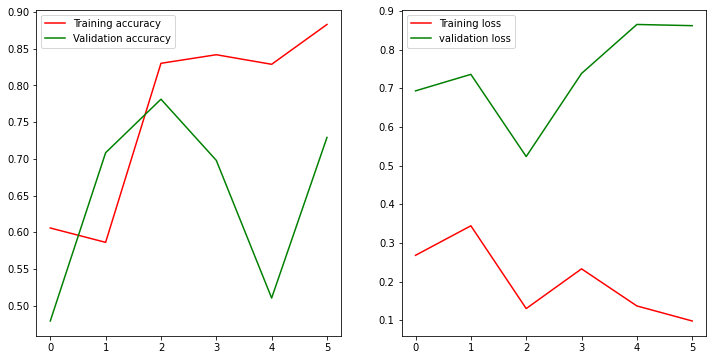

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       0.80      0.79      0.80       188
   PNEUMONIA       0.87      0.88      0.88       312

    accuracy                           0.85       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.85      0.85      0.85       500



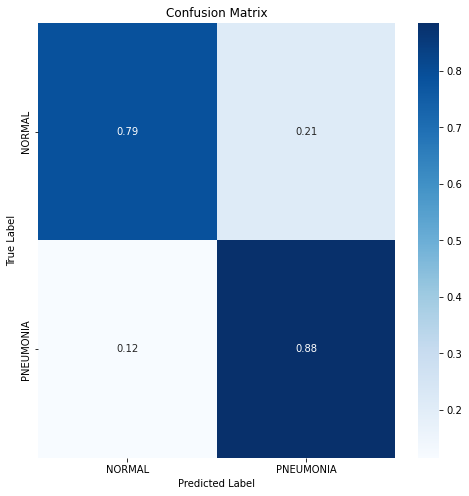

In [36]:
#Use model_eval to get info on images
model_eval(model_3, history_3)

## Model VGG16
Here I use a VGG16 model, which is used for Large-Scale Image Recognition. Three Fully-Connected layers follow a stack of convolutonal layers. The first two have 4096 channels each. The final layer is the soft-max layer. <br>
All hidden layers are equipped with the rectification (ReLU) non-linearity. 

In [37]:
#Initialize model VGG16
model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(80,80,3))
model_vgg16.trainable=False
model_vgg16.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

In [38]:
def vgg_model():
    '''
    A CNN model
    vgg_model -> vgg_model
    '''
    #Initialize the model
    vgg_model = Sequential()
    
    #Add model VGG16
    vgg_model.add(model_vgg16)
    
    #Flatten the layers
    vgg_model.add(Flatten())
    
    #Add fully connected layers
    vgg_model.add(Dropout(0.2))
    vgg_model.add(Dense(128, activation="relu"))
    vgg_model.add(Dense(64, activation="relu"))
    vgg_model.add(Dense(1, activation="sigmoid"))
    
    #Compile the model
    vgg_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
    return vgg_model

In [39]:
# 
vgg_model = vgg_model()

In [40]:
#
history_vgg = vgg_model.fit_generator(train_gen, epochs=20, steps_per_epoch = train_size// batch_size, validation_steps = val_size//batch_size, validation_data=val_gen, class_weight=class_weight, callbacks=callbacks)

Epoch 1/20
163/163 [==============================] - 174s 1s/step - loss: 0.2231 - acc: 0.7841 - val_loss: 0.3125 - val_acc: 0.8958
Epoch 2/20
163/163 [==============================] - 146s 894ms/step - loss: 0.0702 - acc: 0.9298 - val_loss: 0.6507 - val_acc: 0.7292
Epoch 3/20
163/163 [==============================] - 139s 849ms/step - loss: 0.0719 - acc: 0.9275 - val_loss: 0.3470 - val_acc: 0.8646
Epoch 4/20
163/163 [==============================] - 133s 814ms/step - loss: 0.0629 - acc: 0.9363 - val_loss: 0.2830 - val_acc: 0.9167
Epoch 5/20
163/163 [==============================] - 128s 782ms/step - loss: 0.0590 - acc: 0.9381 - val_loss: 0.3053 - val_acc: 0.8750
Epoch 6/20
163/163 [==============================] - 127s 779ms/step - loss: 0.0526 - acc: 0.9475 - val_loss: 0.2822 - val_acc: 0.8958
Epoch 7/20
163/163 [==============================] - 128s 782ms/step - loss: 0.0509 - acc: 0.9469 - val_loss: 0.4672 - val_acc: 0.8333
Epoch 8/20
163/163 [==============================]

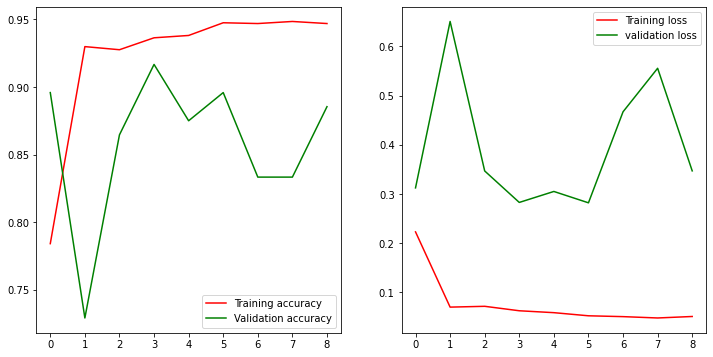

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       0.89      0.68      0.77       188
   PNEUMONIA       0.83      0.95      0.88       312

    accuracy                           0.85       500
   macro avg       0.86      0.81      0.83       500
weighted avg       0.85      0.85      0.84       500



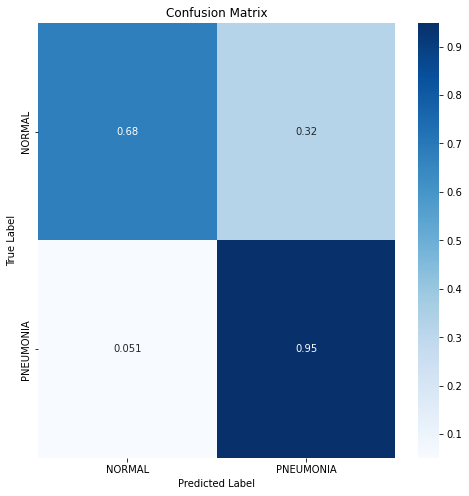

In [41]:
model_eval(vgg_model, history_vgg)

The performance after using declines quite a bit. I will adjust the weights accordingly to see if the next model has any shift in accuracy.

## Model 4

In [42]:
def model_4th():
    '''
    A CNN model (4th iteration)
    '''
    #Initialize the model
    model_4 = Sequential()
    
    #Add a convolutional layer(32 nodes)
    model_4.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(80,80,3)))
    #Add a MaxPooling layer
    model_4.add(MaxPooling2D((2,2)))
    
    #Add a Convolutional layer(128 nodes)
    model_4.add(Conv2D(128, (3,3), activation="relu", padding="same"))
    #Add a MaxPooling layer
    model_4.add(MaxPooling2D((2,2)))
    
    #Add a Convolutional layer(128 nodes)
    model_4.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    #Add a MaxPooling layer
    model_4.add(MaxPooling2D((2,2)))
    
    #Add a Convolutional layer(128 nodes)
    model_4.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    #Add a MaxPooling layer
    model_4.add(MaxPooling2D((2,2)))
    
    #Flatten the layers
    model_4.add(Flatten())
    
    #Add hidden layers
    model_4.add(Dense(128, activation="relu"))
    model_4.add(Dense(256, activation="relu"))
    model_4.add(Dropout(0.1))
    model_4.add(Dense(512, activation="relu"))
    model_4.add(Dropout(0.2))
    model_4.add(Dense(1, activation="sigmoid"))

    model_4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

    model_4.summary()
    return model_4

In [43]:
model_4 = model_4th()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 40, 40, 128)       36992     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 128)      

In [44]:
#Fit the model_4
history_4 = model_4.fit_generator(train_gen, epochs=20, steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size,validation_data=val_gen, class_weight=class_weight, callbacks=callbacks)

Epoch 1/20
163/163 [==============================] - 68s 415ms/step - loss: 0.2554 - acc: 0.5454 - val_loss: 0.6796 - val_acc: 0.7188
Epoch 2/20
163/163 [==============================] - 69s 421ms/step - loss: 0.3150 - acc: 0.7504 - val_loss: 1.4579 - val_acc: 0.6250
Epoch 3/20
163/163 [==============================] - 69s 422ms/step - loss: 0.1403 - acc: 0.8206 - val_loss: 0.9045 - val_acc: 0.6354
Epoch 4/20
163/163 [==============================] - 70s 428ms/step - loss: 0.1045 - acc: 0.8608 - val_loss: 1.2484 - val_acc: 0.6875


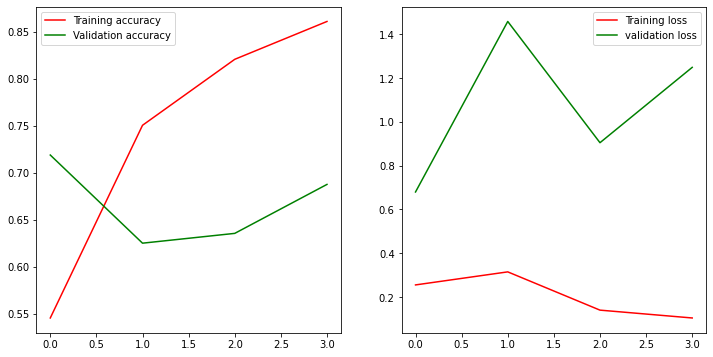

******************************
Classification Report
******************************
              precision    recall  f1-score   support

      NORMAL       0.82      0.70      0.75       188
   PNEUMONIA       0.83      0.91      0.87       312

    accuracy                           0.83       500
   macro avg       0.83      0.80      0.81       500
weighted avg       0.83      0.83      0.82       500



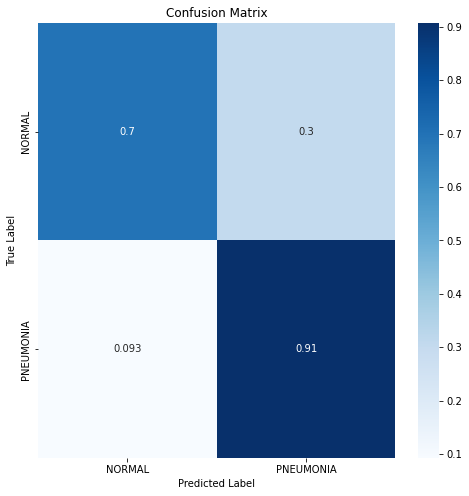

In [45]:
model_eval(model_4, history_4)

### Save and load the models

In [47]:
#Save the weights
model_3.save_weights("saved_model/")

In [49]:
#Load the weights
model_3.load_weights("saved_model/")

In [50]:
#Save the complete model
model_3.save("complete_saved_model/")

INFO:tensorflow:Assets written to: complete_saved_model/assets


## Data Interpretation
In this section, I use the best model to predict Xray images and draw inferences from it.

In [53]:
#Load the best model
best_model = models.load_model("complete_saved_model/")

In [54]:
best_model

In [62]:
# Create an instance of test images and labels 
test_val_datagen = ImageDataGenerator(rescale=1./255)
test = test_val_datagen.flow_from_directory(test_folder, target_size=(80,80),subset="training", batch_size=500, classes=["NORMAL", "PNEUMONIA"], class_mode="binary", shuffle=False)

Found 624 images belonging to 2 classes.


In [63]:
X_test, y_test = next(test)

True Class:  0.0
Predicted Class: 1


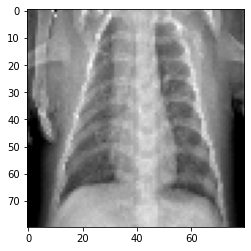

In [68]:
label = y_test[45]
img = X_test[45]

#Get model pred
pred = best_model.predict(np.array([img]))
pred_class = int(pred.round())

#Print true class and image
print("True Class: ", label)
print("Predicted Class:", pred_class)
plt.imshow(img)
plt.show()

In [69]:
explainer = lime_image.LimeImageExplainer()

100%|██████████| 1000/1000 [00:10<00:00, 97.36it/s]


Label: 0.0 prediction: 0


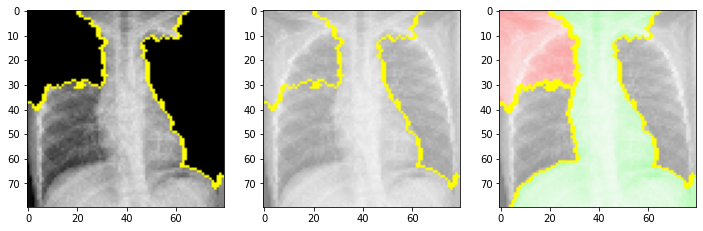

In [86]:
plt.rcParams["figure.figsize"]=[12,5]
def mask_temp(index):
    '''This function uses lime library to find the most important zones
    the model is searching for
    
    Arguments:
    Index -> index of the array 
    '''
    #Initialize label and img 
    label = y_test[index]
    img = X_test[index].astype("double")

    #Predict the img using the best_model
    pred = best_model.predict(np.array([img]))
    pred_class = int(pred.round())
    
    #Use explain_instance from lime package 
    explanation = explainer.explain_instance(img, best_model.predict, top_labels=15, hide_color=None, num_samples=1000)

    #temp, mask gets the important areas in the img 
    #Show image of temp, mask using 
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax[0].imshow(mark_boundaries(temp, mask))

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
    ax[2].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    
    print("Label:", label, "prediction:", pred_class)

mask_temp(3)
  



100%|██████████| 1000/1000 [00:10<00:00, 95.68it/s]


Label: 1.0 prediction: 1


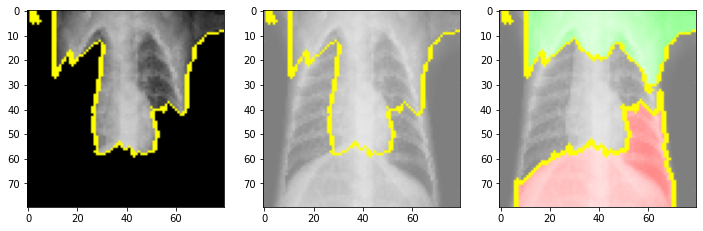

In [90]:
mask_temp(450)

In the images above, the lime packages helps understand which parts X-ray are important and which are not. The green region is the area which my best CNN model found to be important and red zone to be unimportant. The yellow marks the boundary of the red as well as the green zone.

## Conclusions and Recommendations
"A decade of unprecedented progress in artificial intelligence (AI) has demonstrated the potential for many fields—including medicine—to benefit from the insights that AI techniques can extract from data." The link to the whole article can be found [here](#https://www.nature.com/articles/s41746-020-00376-2).<br>

In pneumonia detection, the results are far better than average and maybe could even be better if CNN is tuned to perfection and images are clearer. However, my analysis has revealed tons of new information from data extraction to data modeling. For example, os has been the library to extract images which I recently found out thanks to this project I undertook. In the beginning I was scratching my head using tensorflow, but keras turned out to be far easier and friendlier to use. However, I am back to the drawing board with tensorflow.<br>

**From the analysis, I derive the following conclusions.**

1. The confusion matrix of my best model works 88% percent of the times for infected images and 80% for normal images.
2. Some of the models I created tend to overfit due to weight and layer adjustments.
3. The lime package clearly identifies the most important parts of the images hence giving clarity to what the model is actually doing.<br>

**Here are some of my recommendations:**
1. Clearer X-ray images can lead to improved model accuracy in terms of pneumonia detection.
2. Using Talos libray can further ease the process of modeling it can take multiple hyper parameters and run hundreds of models independently.
3. At this moment, Deep Learning can and does make the jobs of the Doctors and staff easier, so deploying a good model and using it in real time will be of great benefit to the doctors.

